In [1]:
# import libraries
import torch
from torch import nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set seed
seed = 25

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
# load cifar10 dataset
from torchvision import datasets, transforms

save_dir = 'cifar10'

transform = transforms.ToTensor()

train_set = datasets.CIFAR10(save_dir, download=True, train=True, transform=transform)
test_set = datasets.CIFAR10(save_dir, download=True, train=False, transform=transform)

print(train_set)
print(test_set)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10\cifar-10-python.tar.gz to cifar10
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10
    Split: Test
    StandardTransform
Transform: ToTensor()


In [4]:
# randomly create training and validation sets

from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 50000
ntrain = int(0.9*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size)

In [6]:
# CNN model architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)
    
model = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

c:\Users\jonathan\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.74187
   Val loss: 1.51907

EPOCH 1
 Train loss: 1.44398
   Val loss: 1.39923

EPOCH 2
 Train loss: 1.33076
   Val loss: 1.31808

EPOCH 3
 Train loss: 1.25110
   Val loss: 1.28391

EPOCH 4
 Train loss: 1.18219
   Val loss: 1.20741

EPOCH 5
 Train loss: 1.12304
   Val loss: 1.15468

EPOCH 6
 Train loss: 1.07898
   Val loss: 1.14502

EPOCH 7
 Train loss: 1.03108
   Val loss: 1.08712

EPOCH 8
Exiting from training early
test accuracy: 61.760


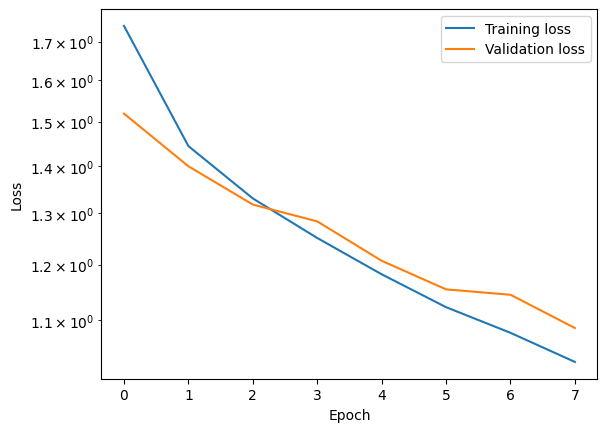

In [7]:
# train model
from tqdm.notebook import tqdm

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=1000):
    train_losses = []
    val_losses = []
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            train_losses.append(total_loss/count)
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
                val_losses.append(total_loss/count)
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return train_losses, val_losses

def test_network(model, test_loader, mode):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

train_losses, val_losses = train_network(model, train_loader, val_loader, criterion, optimizer)
acc, true, pred = test_network(model, test_loader, "test")
plt.semilogy(train_losses, label="Training loss")
plt.semilogy(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")